# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

print("cuda available:", torch.cuda.is_available())
print("torch version:", torch.__version__)
print("CUDA runtime in wheel:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
if torch.cuda.is_available():
    print("device:", torch.cuda.get_device_name(0))
    x = torch.randn(4096, 4096, device='cuda')
    y = x @ x
    torch.cuda.synchronize()
    print("ok, matmul done on:", y.device)

cuda
cuda available: True
torch version: 2.9.1+cu128
CUDA runtime in wheel: 12.8
cuDNN version: 91002
device: NVIDIA GeForce RTX 4090
ok, matmul done on: cuda:0


# b. MNIST Data Loader

In [9]:
tensor_transform = transforms.ToTensor()

batch_size = 256

# transforms.ToTensor 
# 1. 数据类型转换：将输入的图像数据从 PIL.Image 或 numpy.ndarray 
#    转换为 PyTorch 的 torch.Tensor
# 2. 归一化：将图像的像素值从原始范围（通常是 [0, 255]）缩放到 [0, 1]

MNIST_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)

MNIST_loader = torch.utils.data.DataLoader(dataset = MNIST_dataset,
							   batch_size = batch_size,
								 shuffle = True)

print("Number of training samples:", len(MNIST_dataset))


Number of training samples: 60000


# c. Training Function

In [158]:
from math import e
mse = torch.nn.MSELoss()
from IPython.display import clear_output

def loss_func(model, x, reg_func=None, coeff=1e-3):
    output = model(x)
    err = mse(output['imgs'], x)
    logpx_z = -1.0 * torch.sum(err)

    if reg_func is not None:
      reg = reg_func(output)
    else:
      reg = 0.0

    return -1.0 * torch.mean(logpx_z + coeff * reg)

def train(dataloader, model, loss_func, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            batch_size = images.shape[0]
            images = images.reshape(batch_size, -1).to(device)
            loss = loss_func(model, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            avg_loss = running_loss / len(MNIST_dataset) * batch_size
            losses.append(loss.item())

        if epochs <= 100 or (epoch + 1) % (epochs // 10) == 0:
            clear_output(wait=True) 
            tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses


# d. Evaluation Function

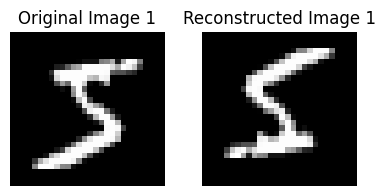

[-2.         -1.33333333 -0.66666667  0.          0.66666667  1.33333333
  2.        ]


In [49]:
# 这个函数对二维latent的x,y轴分别在[-2, 2]内均匀采样，并decode为图像，然后拼接成
# 大图显示
def plot_latent_images(model, n, digit_size=28):
    # linspace(linear space): 这里是在-2到2之间返回n个均匀的数字，
    # 做对二维latent space的均匀采样
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)

    image_width = digit_size * n
    image_height = digit_size * n
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            with torch.no_grad():
                x_decoded = model.decode(z)
            digit = x_decoded.view(digit_size, digit_size).cpu().numpy()
            image[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

# 这个函数展示MNIST中5个样本通过模型encode再decode的效果
def eval(model, count=5):
    # [0]: 仅获取image. [1]是label
    original_imgs = torch.cat([MNIST_dataset[i][0] for i in range(count)])
    with torch.no_grad():
      # reshape: count * 1 * 28 * 28  -->  count * 784
      # 有个1是因为MNIST的图是灰度图，通道数为1（相比之下RGB为3）
      res = model(original_imgs.reshape(count, -1).to(device))
      reconstructed_imgs = res['imgs']
      reconstructed_imgs = reconstructed_imgs.cpu().reshape(*original_imgs.shape)

    fig, axes = plt.subplots(count, 2, figsize=(4, count*2))
    
    if count == 1:
        axes = np.expand_dims(axes, axis=0)
    
    for i in range(count):
        original_image = original_imgs[i].reshape(28, 28)
        axes[i, 0].imshow(original_image, cmap='gray')
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')

        reconstructed_image = reconstructed_imgs[i].reshape(28, 28)
        axes[i, 1].imshow(reconstructed_image, cmap='gray')
        axes[i, 1].set_title(f'Reconstructed Image {i+1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
    
def _fake_model(x): # for test, reverse all pixels
    return {'imgs': torch.flip(x, dims=[1])}

eval(_fake_model, 1)

print(np.linspace(-2, 2, 7))


# **1. AutoEncoder (AE)**

## a. Model


In [5]:
class AE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super().__init__()

        assert hidden_dims[-1] == 2, "always use 2 as the latent dimension for generating a 2D image grid during evaluation"
        self.encoder = torch.nn.Sequential()
        self.decoder = torch.nn.Sequential()
        ##################
        ### Problem 1 (a): finish the implementation for encoder and decoder
        ##################
        
        self.encoder.add_module("enc_fc0", torch.nn.Linear(input_dim, hidden_dims[0]))
        self.encoder.add_module("enc_relu0", torch.nn.ReLU())
        for i in range(1, len(hidden_dims)):
            self.encoder.add_module(f"enc_fc{i}", torch.nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            if i != len(hidden_dims) - 1:
                self.encoder.add_module(f"enc_relu{i}", torch.nn.ReLU())
                
        for i in range(len(hidden_dims)-1, 0, -1):
            self.decoder.add_module(f"dec_fc{i}", torch.nn.Linear(hidden_dims[i], hidden_dims[i-1]))
            self.decoder.add_module(f"dec_relu{i}", torch.nn.ReLU())
        self.decoder.add_module(f"dec_fc0", torch.nn.Linear(hidden_dims[0], input_dim))
        self.decoder.add_module(f"dec_sigmoid", torch.nn.Sigmoid())    

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decode(encoded)
        return {"imgs": decoded}

### Test
hidden_dims = [128, 64, 36, 18, 2]
input_dim = 256
test_tensor = torch.randn([1, input_dim]).to(device)

ae_test = AE(input_dim, hidden_dims).to(device)

with torch.no_grad():
  test_out = ae_test(test_tensor)


## b. Loss Functions and Optimizers


In [11]:
def loss_AE(model, x):
    reconstructed = model(x)['imgs']
    return mse(reconstructed, x)

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

hidden_dims = [128, 32, 16, 2]

ae = AE(input_dim, hidden_dims).to(device)
print(ae)

optimizer_ae = torch.optim.Adam(ae.parameters(),
                                lr = 1e-3,
                                weight_decay = 1e-8)


input_dim:  784
AE(
  (encoder): Sequential(
    (enc_fc0): Linear(in_features=784, out_features=128, bias=True)
    (enc_relu0): ReLU()
    (enc_fc1): Linear(in_features=128, out_features=32, bias=True)
    (enc_relu1): ReLU()
    (enc_fc2): Linear(in_features=32, out_features=16, bias=True)
    (enc_relu2): ReLU()
    (enc_fc3): Linear(in_features=16, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (dec_fc3): Linear(in_features=2, out_features=16, bias=True)
    (dec_relu3): ReLU()
    (dec_fc2): Linear(in_features=16, out_features=32, bias=True)
    (dec_relu2): ReLU()
    (dec_fc1): Linear(in_features=32, out_features=128, bias=True)
    (dec_relu1): ReLU()
    (dec_fc0): Linear(in_features=128, out_features=784, bias=True)
    (dec_sigmoid): Sigmoid()
  )
)


## c. Training


In [12]:
##################
### Problem 1 (b): Train AE
epochs = 30

log_ae = train(MNIST_loader, ae, loss_AE, optimizer_ae, epochs)
##################


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [1/30], Average Loss: 0.0304



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [2/30], Average Loss: 0.0208



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [3/30], Average Loss: 0.0198



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [4/30], Average Loss: 0.0190



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [5/30], Average Loss: 0.0183



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [6/30], Average Loss: 0.0176



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [7/30], Average Loss: 0.0172



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [8/30], Average Loss: 0.0169



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [9/30], Average Loss: 0.0166



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [10/30], Average Loss: 0.0163



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [11/30], Average Loss: 0.0161



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [12/30], Average Loss: 0.0159



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [13/30], Average Loss: 0.0157



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [14/30], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [15/30], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [16/30], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [17/30], Average Loss: 0.0153



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [18/30], Average Loss: 0.0152



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [19/30], Average Loss: 0.0151



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [20/30], Average Loss: 0.0151



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [21/30], Average Loss: 0.0150



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [22/30], Average Loss: 0.0149



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [23/30], Average Loss: 0.0149



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [24/30], Average Loss: 0.0148



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [25/30], Average Loss: 0.0147



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [26/30], Average Loss: 0.0147



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [27/30], Average Loss: 0.0146



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [28/30], Average Loss: 0.0146



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [29/30], Average Loss: 0.0145



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [30/30], Average Loss: 0.0145



## d. Evaluation


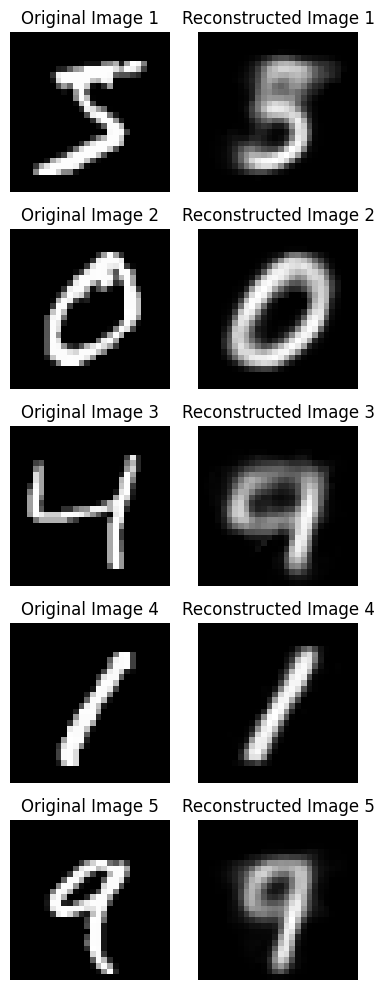

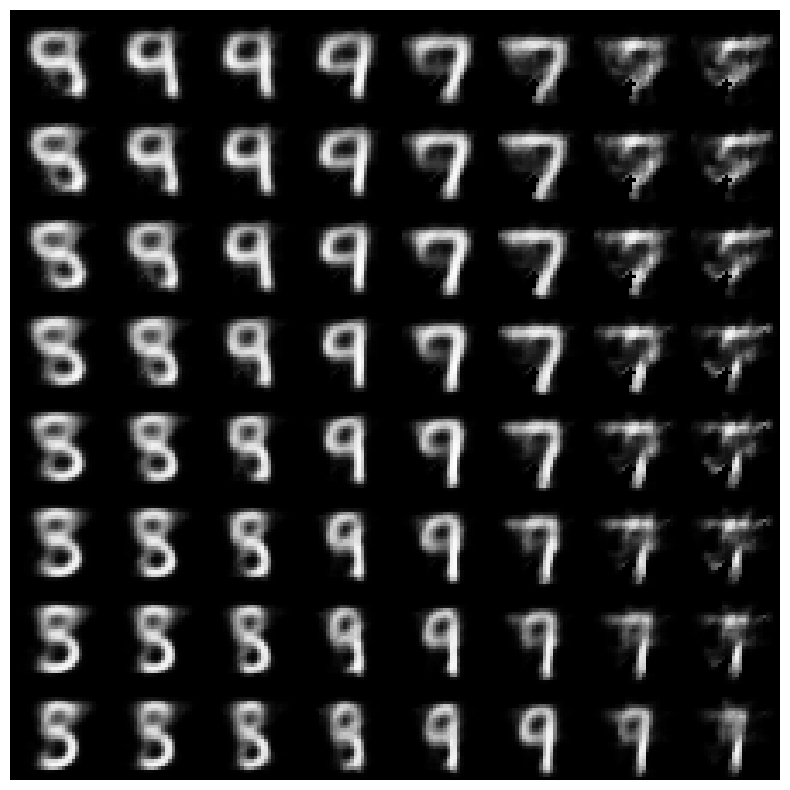

In [77]:
##################
### Problem 1 (b): Evaluate AE
eval(ae)
plot_latent_images(ae, n=8)
##################


# **2. Variational  AutoEncoder (VAE)**
## a. Model

In [40]:
class VAE(torch.nn.Module):
  def __init__(self, input_dim, hidden_dims, decode_dim=-1, use_sigmoid=True):
      '''
      input_dim: The dimensionality of the input data.
      hidden_dims: A list of hidden dimensions for the layers of the encoder and decoder.
      decode_dim: (Optional) Specifies the dimensions to decode, if different from input_dim.
      '''
      super().__init__()

      assert hidden_dims[-1] % 2 == 0, "the last hidden dimension must be even to split into mean and logvar"
      self.z_size = hidden_dims[-1] // 2

      self.encoder = torch.nn.Sequential()
      self.decoder = torch.nn.Sequential()
      ##################
      ### Problem 2(b): finish the implementation for encoder and decoder
      ##################
      
      self.encoder.add_module("enc_fc0", torch.nn.Linear(input_dim, hidden_dims[0]))
      self.encoder.add_module("enc_relu0", torch.nn.ReLU())
      for i in range(1, len(hidden_dims)):
          self.encoder.add_module(f"enc_fc{i}", torch.nn.Linear(hidden_dims[i-1], hidden_dims[i]))
          if i != len(hidden_dims) - 1:
              self.encoder.add_module(f"enc_relu{i}", torch.nn.ReLU())
              
    
      self.decoder.add_module(f"dec_fc{len(hidden_dims)-1}", torch.nn.Linear(self.z_size, hidden_dims[-2]))
      self.decoder.add_module(f"dec_relu{len(hidden_dims)-1}", torch.nn.ReLU())
    
      for i in range(len(hidden_dims)-2, 0, -1):
          self.decoder.add_module(f"dec_fc{i}", torch.nn.Linear(hidden_dims[i], hidden_dims[i-1]))
          self.decoder.add_module(f"dec_relu{i}", torch.nn.ReLU())
      self.decoder.add_module(f"dec_fc0", torch.nn.Linear(hidden_dims[0], decode_dim if decode_dim > 0 else input_dim))
      if use_sigmoid:
          self.decoder.add_module(f"dec_sigmoid", torch.nn.Sigmoid())   
    
          

  def encode(self, x):
      mean, logvar = torch.split(self.encoder(x), split_size_or_sections=[self.z_size, self.z_size], dim=-1)
      return mean, logvar

  def reparameterize(self, mean, logvar, n_samples_per_z=1):
      ##################
      ### Problem 2(c): finish the implementation for reparameterization
      ##################
      std = torch.exp(0.5 * logvar)
      eps = torch.randn_like(std)
      
    #   print("repara-mean: ", mean.shape)
    #   print("repara-std: ", std.shape)
    #   print("repara-eps: ", eps.shape)
      
      return mean + eps * std

  def decode(self, z):
      probs = self.decoder(z)
      return probs

  def forward(self, x, n_samples_per_z=1):
    #   print("x.shape before encode", x.shape)
      mean, logvar = self.encode(x)
    #   print("mean, logvar shape after encode", mean.shape, logvar.shape)


      batch_size, latent_dim = mean.shape
      if n_samples_per_z > 1:
        mean = mean.unsqueeze(1).expand(batch_size, n_samples_per_z, latent_dim)
        logvar = logvar.unsqueeze(1).expand(batch_size, n_samples_per_z, latent_dim)

        mean = mean.contiguous().view(batch_size * n_samples_per_z, latent_dim)
        logvar = logvar.contiguous().view(batch_size * n_samples_per_z, latent_dim)
        
    #   print("mean, logvar shape after expansian", mean.shape, logvar.shape)
        
      z = self.reparameterize(mean, logvar, n_samples_per_z)
    #   print("z.shape", z.shape)
      x_probs = self.decode(z)

      x_probs = x_probs.reshape(batch_size, n_samples_per_z, -1)

    #   print("x_probs after decode", x_probs.shape)

      x_probs = torch.mean(x_probs, dim=[1])

    #   print("x_probs after mean", x_probs.shape)
      

      return {
          "imgs": x_probs,
          "z": z,
          "mean": mean,
          "logvar": logvar
      }

### Test
hidden_dims = [128, 64, 36, 18, 18]
input_dim = 256
test_tensor = torch.randn([1, input_dim]).to(device)

vae_test = VAE(input_dim, hidden_dims).to(device)

print(vae_test)

with torch.no_grad():
  test_out = vae_test(test_tensor, n_samples_per_z=2)


VAE(
  (encoder): Sequential(
    (enc_fc0): Linear(in_features=256, out_features=128, bias=True)
    (enc_relu0): ReLU()
    (enc_fc1): Linear(in_features=128, out_features=64, bias=True)
    (enc_relu1): ReLU()
    (enc_fc2): Linear(in_features=64, out_features=36, bias=True)
    (enc_relu2): ReLU()
    (enc_fc3): Linear(in_features=36, out_features=18, bias=True)
    (enc_relu3): ReLU()
    (enc_fc4): Linear(in_features=18, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (dec_fc4): Linear(in_features=9, out_features=18, bias=True)
    (dec_relu4): ReLU()
    (dec_fc3): Linear(in_features=18, out_features=36, bias=True)
    (dec_relu3): ReLU()
    (dec_fc2): Linear(in_features=36, out_features=64, bias=True)
    (dec_relu2): ReLU()
    (dec_fc1): Linear(in_features=64, out_features=128, bias=True)
    (dec_relu1): ReLU()
    (dec_fc0): Linear(in_features=128, out_features=256, bias=True)
    (dec_sigmoid): Sigmoid()
  )
)


## b. Loss Functions

### Loss 1: Stoachastic Gradient Variational Bayes (SGVB) Estimator

VAEs are trained by maximizing the Evidence Lower Bound (ELBO) on the marginal log-likelihood:
$$\log p(x) \geq \mathbb{E}_{q(z|x)}[\log\frac{p(x, z)}{q(z|x)}] = \mathrm{ELBO},$$

where $x$ is the data (binary images for MNIST) and $z$ is the latent code.

In practice, the above expectation is estimated using Monte Carlo sampling, yielding the generic Stoachastic Gradient Variational Bayes (SGVB) estimator,
$$\mathrm{ELBO} \approx \sum_{i, j} [\log p(x_i|z_{i, j}) + \log p(z_{i, j}) - \log q(z_{i, j}|x_i)], $$
where $z_{i, j}$ is sampled from $ q(z|x_i) = \mathcal{N}(z;\mu_i, \sigma^2_i \mathbf{I})$. In this assignment, we only sample one $z_{i,j}$ for each $x_i$ (see the function ``reparameterize()`` in the ``VAE()`` class).


$$
\begin{aligned}
p(x; \mu, \sigma^2) &= \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left[-\frac{(x - \mu)^2}{2\sigma^2}\right] \\
\log p(x; \mu, \sigma^2) &= \log \left[ \frac{1}{\sqrt{2\pi \sigma^2}} \right] - \frac{(x - \mu)^2} {2\sigma^2} \\
&= -\frac{1}{2} \log(2\pi) - \frac{1}{2}\log\sigma^2 - \frac{(x - \mu)^2} {2\sigma^2}\\
&= -\frac{1}{2} \left[\log(2\pi) +\text{logvar}+\frac{(x-\text{mean})^2}{\exp(\text{logvar})}\right] 
\end{aligned}
$$

In [ ]:
##### Loss 1: SGVB #####
log2pi = torch.log(2.0 * torch.tensor(np.pi)).to(device)
torch_zero = torch.tensor(0.0).to(device)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    ##################
    ### Problem 2(d): finish the implementation for the log-probability for normal distribution with mean and var
    ##################
    return -0.5 * torch.sum(log2pi + logvar + (sample - mean) ** 2 / torch.exp(logvar), dim=raxis)

# 这里只计算ELBO的KL散度项，重构项（对于高斯分布就是MSE）另外考虑
def loss_SGVB(output):
    logpz = log_normal_pdf(output['z'], torch_zero, torch_zero)
    logqz_x = log_normal_pdf(output['z'], output['mean'], output['logvar'])
    return logpz -logqz_x


### Loss 2: KL Divergence w/o Estimation
In many cases, Monte Carlo sampling is not necessary to estimate all the terms of ELBO, as some terms can be integrated analytically. In the assignment, you derived the cases where the ELBO can be expressed as an analytical KL-divergence plus the expected reconstruction error, specifically when both $q(z|x)$ and $p(z)$ are Gaussian distributions:
$$\mathrm{ELBO} ≈ -D_{KL}(q(z|x) || p(z)) + \sum_{i, j} \log p(x_i|z_{i, j}) = \\\frac{1}{2}\sum_{d}(1+\log((\sigma_d)^2) - (\mu_d)^2 - (\sigma_d)^2) + \sum_{i, j} \log p(x_i|z_{i, j})$$

In [36]:
##### Loss 2: KL w/o Estimation #####
def loss_KL_wo_E(output):
    var = torch.exp(output['logvar'])
    logvar = output['logvar']
    mean = output['mean']

    return -0.5 * torch.sum(torch.pow(mean, 2)
                            + var - 1.0 - logvar,
                            dim=[1])


## c. Verifying loss 1 == loss 2


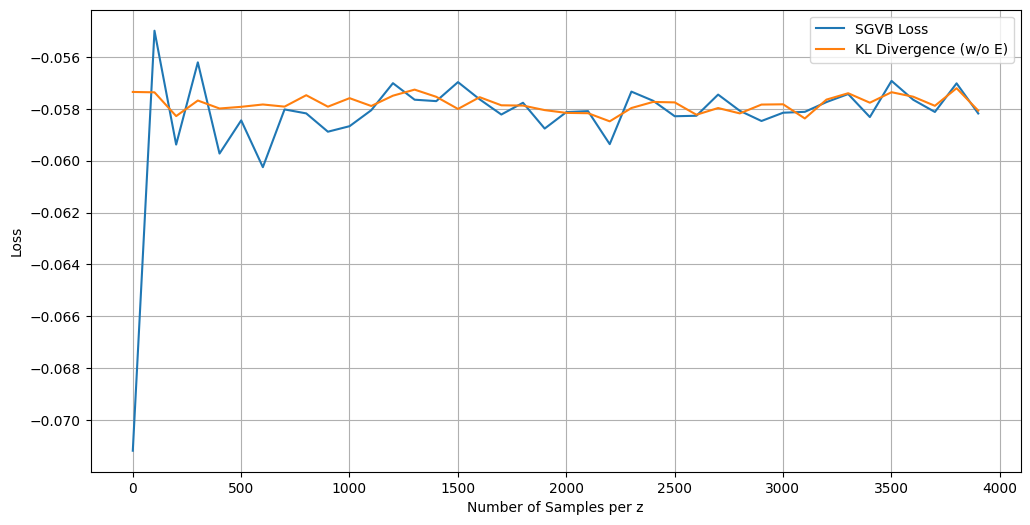

In [41]:
##################
### Problem 3(b): Check if the analytical KL divergence matches the Monte Carlo estimate.
hidden_dims = [128, 32, 16, 4]
image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
vae_test = VAE(input_dim, hidden_dims).to(device)

all_l_sgvb, all_KL_wo_E = [], []
all_n_samples_per_z = list(range(1, 4000, 100))

with torch.no_grad():
    for n_samples_per_z in all_n_samples_per_z:
        for _, (imgs, _) in enumerate(MNIST_loader):
            batch_size = imgs.shape[0]
            imgs = imgs.reshape(batch_size, -1).to(device)

            output = vae_test(imgs, n_samples_per_z=n_samples_per_z)

            l_sgvb = torch.mean(loss_SGVB(output))
            l_KL_wo_E = torch.mean(loss_KL_wo_E(output))

            all_l_sgvb.append(l_sgvb.item())
            all_KL_wo_E.append(l_KL_wo_E.item())
            break

# Plot the two curves
plt.figure(figsize=(12, 6))

plt.plot(all_n_samples_per_z, all_l_sgvb, label='SGVB Loss')
plt.plot(all_n_samples_per_z, all_KL_wo_E, label='KL Divergence (w/o E)')

plt.xlabel('Number of Samples per z')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()
##################


## d. Training with ELBO loss



In [55]:
##################
### Problem 3(c): Train VAE with ELBO loss
epochs = 30

hidden_dims = [128, 32, 16, 4]
assert hidden_dims[-1] == 4, "always use 4 as the latent dimension for generating a 2D image grid during evaluation"

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

vae_sgvb = VAE(input_dim, hidden_dims).to(device)
print(vae_sgvb)

coeff = 1e-3

optimizer_vae_sgvb = torch.optim.Adam(vae_sgvb.parameters(),
                                lr = 1e-4,
                                weight_decay = 1e-8)

log_vae_sgvb = train(MNIST_loader, vae_sgvb, lambda model, x: loss_func(model, x, reg_func=loss_SGVB, coeff=1e-4), optimizer_vae_sgvb, epochs)
##################


input_dim:  784
VAE(
  (encoder): Sequential(
    (enc_fc0): Linear(in_features=784, out_features=128, bias=True)
    (enc_relu0): ReLU()
    (enc_fc1): Linear(in_features=128, out_features=32, bias=True)
    (enc_relu1): ReLU()
    (enc_fc2): Linear(in_features=32, out_features=16, bias=True)
    (enc_relu2): ReLU()
    (enc_fc3): Linear(in_features=16, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (dec_fc3): Linear(in_features=2, out_features=16, bias=True)
    (dec_relu3): ReLU()
    (dec_fc2): Linear(in_features=16, out_features=32, bias=True)
    (dec_relu2): ReLU()
    (dec_fc1): Linear(in_features=32, out_features=128, bias=True)
    (dec_relu1): ReLU()
    (dec_fc0): Linear(in_features=128, out_features=784, bias=True)
    (dec_sigmoid): Sigmoid()
  )
)


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [1/30], Average Loss: 0.0559



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [2/30], Average Loss: 0.0273



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [3/30], Average Loss: 0.0260



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [4/30], Average Loss: 0.0250



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [5/30], Average Loss: 0.0237



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [6/30], Average Loss: 0.0226



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [7/30], Average Loss: 0.0220



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [8/30], Average Loss: 0.0217



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [9/30], Average Loss: 0.0214



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [10/30], Average Loss: 0.0211



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [11/30], Average Loss: 0.0209



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [12/30], Average Loss: 0.0207



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [13/30], Average Loss: 0.0206



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [14/30], Average Loss: 0.0204



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [15/30], Average Loss: 0.0203



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [16/30], Average Loss: 0.0202



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [17/30], Average Loss: 0.0201



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [18/30], Average Loss: 0.0200



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [19/30], Average Loss: 0.0199



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [20/30], Average Loss: 0.0198



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [21/30], Average Loss: 0.0197



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [22/30], Average Loss: 0.0196



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [23/30], Average Loss: 0.0195



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [24/30], Average Loss: 0.0193



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [25/30], Average Loss: 0.0192



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [26/30], Average Loss: 0.0191



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [27/30], Average Loss: 0.0190



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [28/30], Average Loss: 0.0189



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [29/30], Average Loss: 0.0189



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [30/30], Average Loss: 0.0188



## e. Evaluation

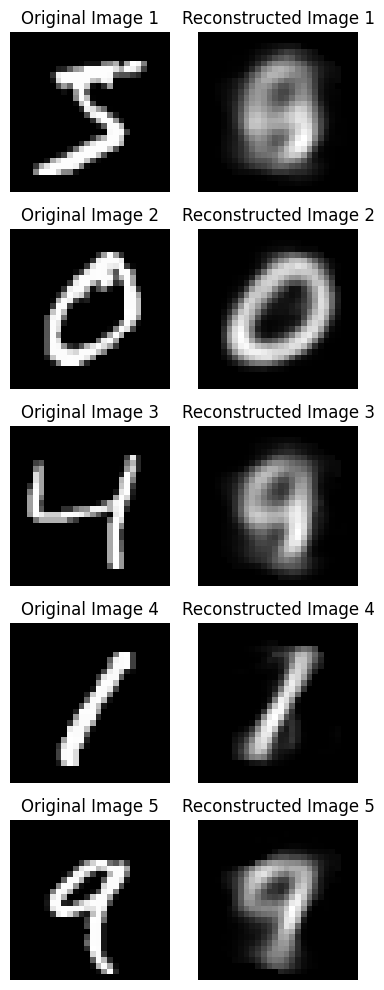

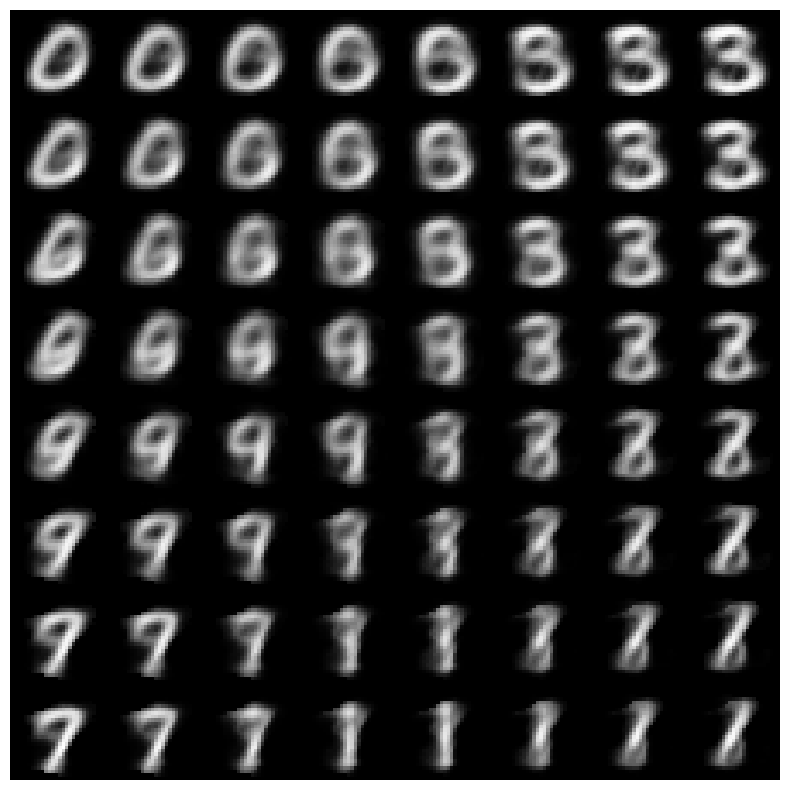

In [56]:
##################
### Problem 3(c): Evaluate VAE with ELBO loss
eval(vae_sgvb)
plot_latent_images(vae_sgvb, n=8)
##################


## f. Training with KL Divergence w/o Estimation

In [ ]:
##################
### Problem 3(c): Train VAE with analytical KL
epochs = 100

hidden_dims = [128, 64, 8]
# assert hidden_dims[-1] == 4, "always use 4 as the latent dimension for generating a 2D image grid during evaluation"

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

vae_kl_wo_e = VAE(input_dim, hidden_dims).to(device)
print(vae_kl_wo_e)

optimizer_vae_kl_wo_e = torch.optim.Adam(vae_kl_wo_e.parameters(),
                                lr = 1e-3,
                                weight_decay = 1e-8)

log_vae_kl_wo_e = train(MNIST_loader, vae_kl_wo_e, lambda model, x: loss_func(model, x, reg_func=loss_KL_wo_E, coeff=1e-4), optimizer_vae_kl_wo_e, epochs)
##################

## 相比原始参数，这里做了以下调整：
# 1. 20 epochs -> 100 epochs， 增加训练轮数
# 2. learning rate 1e-4 -> 1e-3, 加快学习
# 3. coeff 1e-3 -> 1e-4, 减弱对p(z)的高斯正则化

# 在以上设定下，重建效果好于默认配置，模糊的边缘开始变锐利，但对于复杂的图仍然不佳，比较凌乱的5仍然像8，比较潦草的4仍然像9。

# 4. 修改设定，将latent维度从2改为4，删掉一个中间层
# 该设定下，模型参数量变小了，但重建效果有明显提升，4不再像9,5不再像8。




input_dim:  784
VAE(
  (encoder): Sequential(
    (enc_fc0): Linear(in_features=784, out_features=128, bias=True)
    (enc_relu0): ReLU()
    (enc_fc1): Linear(in_features=128, out_features=64, bias=True)
    (enc_relu1): ReLU()
    (enc_fc2): Linear(in_features=64, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (dec_fc2): Linear(in_features=4, out_features=64, bias=True)
    (dec_relu2): ReLU()
    (dec_fc1): Linear(in_features=64, out_features=128, bias=True)
    (dec_relu1): ReLU()
    (dec_fc0): Linear(in_features=128, out_features=784, bias=True)
    (dec_sigmoid): Sigmoid()
  )
)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [1/100], Average Loss: 0.0279



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [2/100], Average Loss: 0.0178



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [3/100], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [4/100], Average Loss: 0.0147



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [5/100], Average Loss: 0.0140



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [6/100], Average Loss: 0.0136



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [7/100], Average Loss: 0.0133



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [8/100], Average Loss: 0.0130



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [9/100], Average Loss: 0.0128



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [10/100], Average Loss: 0.0126



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [11/100], Average Loss: 0.0125



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [12/100], Average Loss: 0.0124



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [13/100], Average Loss: 0.0122



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [14/100], Average Loss: 0.0121



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [15/100], Average Loss: 0.0120



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [16/100], Average Loss: 0.0119



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [17/100], Average Loss: 0.0119



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [18/100], Average Loss: 0.0118



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [19/100], Average Loss: 0.0117



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [20/100], Average Loss: 0.0116



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [21/100], Average Loss: 0.0116



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [22/100], Average Loss: 0.0115



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [23/100], Average Loss: 0.0115



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [24/100], Average Loss: 0.0114



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [25/100], Average Loss: 0.0114



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [26/100], Average Loss: 0.0113



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [27/100], Average Loss: 0.0113



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [28/100], Average Loss: 0.0113



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [29/100], Average Loss: 0.0112



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [30/100], Average Loss: 0.0112



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [31/100], Average Loss: 0.0111



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [32/100], Average Loss: 0.0111



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [33/100], Average Loss: 0.0111



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [34/100], Average Loss: 0.0111



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [35/100], Average Loss: 0.0110



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [36/100], Average Loss: 0.0110



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [37/100], Average Loss: 0.0110



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [38/100], Average Loss: 0.0110



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [39/100], Average Loss: 0.0109



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [40/100], Average Loss: 0.0109



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [41/100], Average Loss: 0.0109



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [42/100], Average Loss: 0.0109



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [43/100], Average Loss: 0.0108



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [44/100], Average Loss: 0.0108



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [45/100], Average Loss: 0.0108



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [46/100], Average Loss: 0.0108



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [47/100], Average Loss: 0.0108



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [48/100], Average Loss: 0.0108



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [49/100], Average Loss: 0.0107



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [50/100], Average Loss: 0.0107



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [51/100], Average Loss: 0.0107



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [52/100], Average Loss: 0.0107



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [53/100], Average Loss: 0.0107



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [54/100], Average Loss: 0.0107



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [55/100], Average Loss: 0.0107



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [56/100], Average Loss: 0.0106



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [57/100], Average Loss: 0.0106



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [58/100], Average Loss: 0.0106



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [59/100], Average Loss: 0.0106



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [60/100], Average Loss: 0.0106



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [61/100], Average Loss: 0.0106



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [62/100], Average Loss: 0.0106



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [63/100], Average Loss: 0.0105



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [64/100], Average Loss: 0.0105



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [65/100], Average Loss: 0.0105



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [66/100], Average Loss: 0.0105



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [67/100], Average Loss: 0.0105



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [68/100], Average Loss: 0.0105



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [69/100], Average Loss: 0.0105



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [70/100], Average Loss: 0.0105



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [71/100], Average Loss: 0.0105



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [72/100], Average Loss: 0.0105



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [73/100], Average Loss: 0.0105



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [74/100], Average Loss: 0.0104



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [75/100], Average Loss: 0.0104



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [76/100], Average Loss: 0.0104



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [77/100], Average Loss: 0.0104



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [78/100], Average Loss: 0.0104



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [79/100], Average Loss: 0.0104



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [80/100], Average Loss: 0.0104



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [81/100], Average Loss: 0.0104



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [82/100], Average Loss: 0.0104



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [83/100], Average Loss: 0.0104



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [84/100], Average Loss: 0.0104



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [85/100], Average Loss: 0.0104



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [86/100], Average Loss: 0.0104



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [87/100], Average Loss: 0.0104



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [88/100], Average Loss: 0.0103



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [89/100], Average Loss: 0.0103



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [90/100], Average Loss: 0.0103



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [91/100], Average Loss: 0.0103



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [92/100], Average Loss: 0.0103



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [93/100], Average Loss: 0.0103



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [94/100], Average Loss: 0.0103



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [95/100], Average Loss: 0.0103



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [96/100], Average Loss: 0.0103



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [97/100], Average Loss: 0.0103



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [98/100], Average Loss: 0.0103



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [99/100], Average Loss: 0.0103



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [100/100], Average Loss: 0.0103



## g. Evaluation

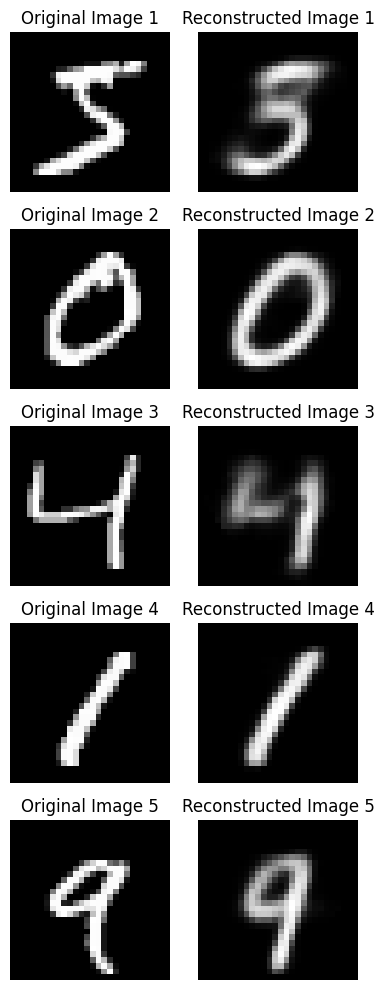

In [76]:
##################
### Problem 3(c): Evaluate VAE with analytical KL
eval(vae_kl_wo_e)
# plot_latent_images(vae_kl_wo_e, n=8)
##################


# **3. Torus**

## a. Data Generation

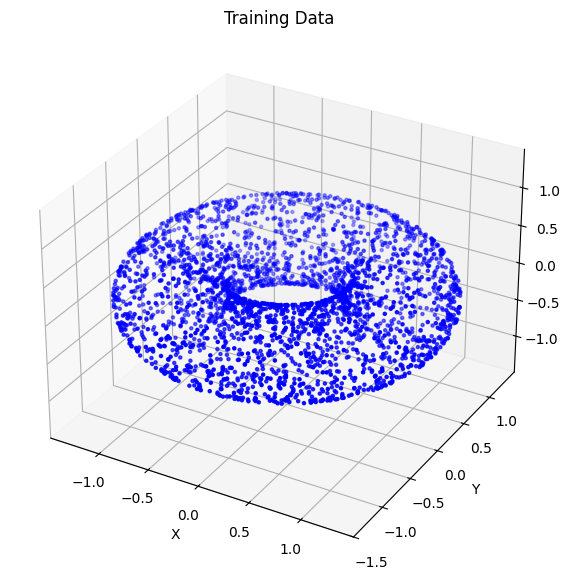

In [143]:
def generate_torus_point_cloud(R, r, num_points=1000, seed=1234):
    """
    Parameters:
    - R: Major radius of the torus (distance from the center of the tube to the center of the torus).
    - r: Minor radius of the torus (radius of the tube).
    - num_points: Number of points to sample in the point cloud.

    Returns:
    - x, y, z: Arrays containing the x, y, and z coordinates of the sampled points.
    """
    np.random.seed(seed)
    u = np.random.uniform(0, 2 * np.pi, num_points)
    np.random.seed(seed+1)
    v = np.random.uniform(0, 2 * np.pi, num_points)

    x = (R + r * np.cos(v)) * np.cos(u)
    y = (R + r * np.cos(v)) * np.sin(u)
    z = r * np.sin(v)

    points = np.vstack((x, y, z)).T

    return points

def plot_torus_point_cloud(x, y, z, ax, color='b', name='Training Data'):
    """
    Plots the 3D point cloud of a torus.
    """
    ax.scatter(x, y, z, c=color, marker='o', s=5)

    # Set equal scaling for all axes
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0

    mid_x = (x.max() + x.min()) * 0.5
    mid_y = (y.max() + y.min()) * 0.5
    mid_z = (z.max() + z.min()) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(name)
    return ax

class TorusPointCloudDataset(torch.utils.data.Dataset):
    def __init__(self, R, r, num_points=1000):
        """
        Args:
            R (float): Major radius of the torus.
            r (float): Minor radius of the torus.
            num_points (int): Number of points to generate.
        """
        points = generate_torus_point_cloud(R, r, num_points)
        self.points = torch.tensor(points, dtype=torch.float32)

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        return self.points[idx], 0 # dummy label

R = 1.0
r = 0.5
num_points = 3000

torus_pc_dataset = TorusPointCloudDataset(R, r, num_points)
torus_pc_dataloader = torch.utils.data.DataLoader(torus_pc_dataset, batch_size=3000, shuffle=True)


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
plot_torus_point_cloud(torus_pc_dataset.points[:, 0], torus_pc_dataset.points[:, 1], torus_pc_dataset.points[:, 2], ax)
plt.show()


## b. Network Architecture

In [159]:
# 空间编码：受Fourier变换启发，将3D坐标通过一系列正弦和余弦函数映射到更高维空间，在频域做“展开”
# dimension中6的来源：2（sin, cos) * 3（x,y,z）= 6

class PositionalEncoding3D(torch.nn.Module):
    def __init__(self, num_frequencies=10):
        """
        Initializes the positional encoding for 3D coordinates.

        Args:
            num_frequencies (int): The number of different frequencies to use for encoding.
        """
        super().__init__()
        self.num_frequencies = num_frequencies
        self.frequencies = 2 ** torch.arange(num_frequencies, dtype=torch.float32)

    def forward(self, points):
        """
        Applies positional encoding to the 3D points.

        Args:
            points (torch.Tensor): N x 3 tensor of 3D coordinates.

        Returns:
            torch.Tensor: N x (6*num_frequencies) tensor of encoded coordinates.
        """
        encoded_points = []
        for i in range(points.shape[1]):  # For each dimension (x, y, z)
            for freq in self.frequencies:
                encoded_points.append(torch.sin(freq * points[:, i:i+1]))
                encoded_points.append(torch.cos(freq * points[:, i:i+1]))
        return torch.cat(encoded_points, dim=-1)

###############
### Problem 4(c): Create your own VAE
###############

# 我们把模型的输出视为球坐标，在decode时额外做一次转换变为笛卡尔坐标，以实现正确的插值行为
class PolarVAE(VAE):
    def decode(self, z):
      probs =  self.decoder(z) 
      r = probs[:, 0:1]
      theta = probs[:, 1:2]
      phi = probs[:, 2:3]
      rx = r * torch.sin(theta) * torch.cos(phi)
      ry = r * torch.sin(theta) * torch.sin(phi)
      rz = r * torch.cos(theta)
      return torch.cat([rx, ry, rz], dim=-1)

class PointVAE(torch.nn.Module):
    def __init__(self, hidden_dims):
        super().__init__()

        self.pos_enc = PositionalEncoding3D(10)
        #############
        ### Problem 4(c): Create your own VAE
        self.vae = PolarVAE(input_dim=self.pos_enc.num_frequencies * 6, hidden_dims=hidden_dims, decode_dim=3, use_sigmoid=False)
        #############

    def forward(self, x):
        emb = self.pos_enc(x)
        return self.vae(emb)



## c. Training

In [163]:


#############
### Problem 4(a): Train VAE on torus data
epochs = 1000

hidden_dims = [32, 20, 10, 6] # -> 2/3 dim

point_vae = PointVAE(hidden_dims).to(device)
print(point_vae)

optimizer_point_vae = torch.optim.Adam(point_vae.parameters(),
                                lr = 1e-3,
                                weight_decay = 1e-8)

log_point_vae = train(torus_pc_dataloader, point_vae, lambda model, x: loss_func(model, x, reg_func=loss_KL_wo_E, coeff=1e-4), optimizer_point_vae, epochs)
#############


----
Epoch [1000/1000], Average Loss: 0.0002



## d. Evaluation on Reconstruction

<Axes3D: title={'center': 'Decoded Data'}, xlabel='X', ylabel='Y', zlabel='Z'>

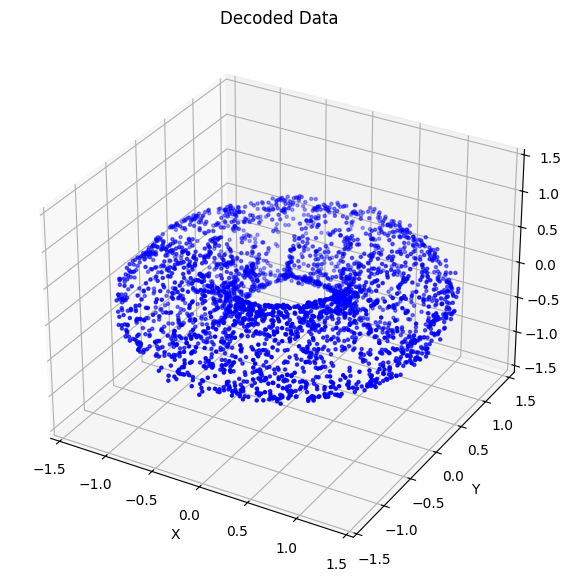

In [164]:
#############
### Problem 4(a): Evaluation on reconstruction
with torch.no_grad():
  output = point_vae(torus_pc_dataset.points.to(device))
  decoded_pc = output['imgs'].cpu().numpy()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
plot_torus_point_cloud(decoded_pc[:, 0], decoded_pc[:, 1], decoded_pc[:, 2], ax, name="Decoded Data")
#############


## e. Evaluation on Interpolation

6


/tmp/ipykernel_167294/470380799.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = point_vae.vae.decode(torch.tensor(latent_vecs).to(device))


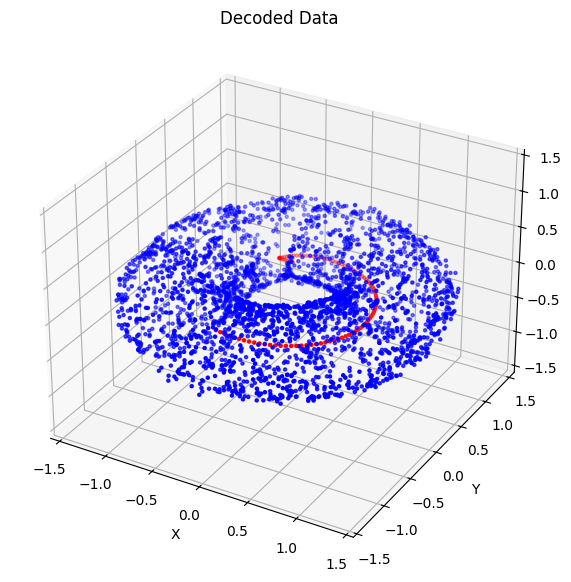

In [167]:
#############
### Problem 4(v): Evaluation on linear interpolation
z0 = point_vae(torch.tensor([[0.0, 1.0, 0.]]).to(device))['z']
z1 = point_vae(torch.tensor([[0.0, -1.0, 0.]]).to(device))['z']

print(hidden_dims[-1])
num_steps = 100

weights = torch.linspace(0, 1, num_steps).view(-1, 1).to(device)
latent_vecs = weights * z0 + (1 - weights) * z1

with torch.no_grad():
    outputs = point_vae.vae.decode(torch.tensor(latent_vecs).to(device))

lin_traj = outputs.cpu().numpy()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
plot_torus_point_cloud(lin_traj[:, 0], lin_traj[:, 1], lin_traj[:, 2], ax, color='r', name="Decoded Data")
plot_torus_point_cloud(decoded_pc[:, 0], decoded_pc[:, 1], decoded_pc[:, 2], ax, name="Decoded Data")
plt.show()
#############
